Для начала получим информацию о санкциях (в виде словаря)

In [1]:
from bs4 import BeautifulSoup
import urllib.request
from collections import defaultdict

In [2]:
def get_html_page(url):
    html_page = urllib.request.urlopen(url).read()
    fp = urllib.request.urlopen(url)
    mybytes = fp.read()
    try:
        html_page = mybytes.decode("utf8")
    except UnicodeDecodeError:
        html_page = mybytes
    fp.close()
    return html_page

In [3]:
url = 'https://www.rferl.org/a/russia-sanctions-timeline/29477179.html'
html_page = get_html_page(url)
soup = BeautifulSoup(html_page, 'html.parser')
sanctions = defaultdict(list)
categories_of_sanctions = ['Financial', 'Economic', 'Diplomatic', 'Corporate', 'Extension']

In [4]:
def get_sanction_source(sanction_info):
    source_container = sanction_info.find(class_='s-countries-wrapper')
    img = source_container.find_all('img')[0]
    if img['src'] == 'https://docs.rferl.org/Infographics/2018/2018_09/2018_09_Sanctions_Timeline//assets/flags/us.svg':
        return 'US'
    elif img['src'] == 'https://docs.rferl.org/Infographics/2018/2018_09/2018_09_Sanctions_Timeline//assets/flags/ru.svg':
        return 'RU'
    elif img['src'] == 'https://docs.rferl.org/Infographics/2018/2018_09/2018_09_Sanctions_Timeline//assets/flags/eu.svg':
        return 'EU'
    return None

In [5]:
from datetime import datetime, timedelta

In [6]:
for year_container in soup.find_all(class_='year-wrapper'):
    year = year_container.find('h1').get_text()
    for sanction_info in year_container.find_all(class_='s'):
        date = sanction_info.find('h2').get_text()
        source = get_sanction_source(sanction_info)
        if source not in ['US', 'EU']:
            continue
        categories = []
        details = sanction_info.find(class_='s-details').get_text()
        for category in categories_of_sanctions:
            if category in details:
                categories.append(category)
        if not categories:
            continue
        
        try:
            date_time_obj = datetime.strptime(date + ' ' + year, '%B %d %Y')
        except ValueError:
            date_time_obj = datetime.strptime(date + ' ' + year, '%d %B %Y')
        sanctions[date_time_obj.date()].append(dict(source=source, categories=categories))

In [7]:
sanctions

defaultdict(list,
            {datetime.date(2014, 3, 3): [{'source': 'US',
               'categories': ['Financial', 'Economic']}],
             datetime.date(2014, 3, 20): [{'source': 'EU',
               'categories': ['Diplomatic']},
              {'source': 'US', 'categories': ['Corporate']}],
             datetime.date(2014, 3, 25): [{'source': 'EU',
               'categories': ['Diplomatic']}],
             datetime.date(2014, 3, 27): [{'source': 'US',
               'categories': ['Economic']}],
             datetime.date(2014, 3, 28): [{'source': 'US',
               'categories': ['Diplomatic']}],
             datetime.date(2014, 4, 11): [{'source': 'US',
               'categories': ['Corporate']}],
             datetime.date(2014, 4, 28): [{'source': 'US',
               'categories': ['Economic', 'Corporate']}],
             datetime.date(2014, 5, 12): [{'source': 'EU',
               'categories': ['Corporate']}],
             datetime.date(2014, 7, 16): [{'source': 'US

In [8]:
import waybackpy
from waybackpy.exceptions import WaybackError

In [9]:
KEYWORDS = ['russia', 'moscow', 'kremlin', 'putin', 'medvedev', 'ruble', 'sanction', 'ukraine', 'crimea']

In [10]:
user_agent = "Mozilla/5.0 (Windows NT 5.1; rv:40.0) Gecko/20100101 Firefox/40.0"

In [11]:
def get_twits_from_archive(date, archive, twits):
    url_twitter = archive.archive_url
    html_page_twitter = get_html_page(url_twitter)
    if html_page_twitter is None:
        return
    soup = BeautifulSoup(html_page_twitter, 'html.parser')
    for twit in soup.find_all('li', class_='js-stream-item stream-item stream-item') + soup.find_all('li', class_='js-stream-item stream-item stream-item expanding-stream-item'):
        text = twit.find('p').get_text()
        if any(word in text.lower() for word in KEYWORDS) and text not in twits:
            print(date, text)
            print('--------------------------------------------------')
            twits[text] = date

Итак, сначала получим информацию о твитах Трампа (оставим только те, которые соответствуют ключевым словам, в промежутке с 1 октября 2016 года до 31 августа 2018 года).

In [12]:
trump_twits = dict()
url_trump_twitter = 'http://twitter.com/realdonaldtrump'
wayback_trump = waybackpy.Url(url_trump_twitter, user_agent)

In [13]:
start_trump_date = datetime.strptime('October 1 2016', '%B %d %Y').date()
end_trump_date = datetime.strptime('August 31 2018', '%B %d %Y').date()

In [14]:
delta = 2

In [15]:
def get_twits(wayback, start_date, end_date, twits):
    for date, sanctions_list in sanctions.items():
        if all(sanction['source'] != 'US' for sanction in sanctions_list):
            continue

        if (end_date is not None and date > end_date) or (start_date is not None and date < start_date):
            continue
            
        try:
            archive = wayback.near(year=date.year, month=date.month, day=date.day)
            get_twits_from_archive(date, archive, twits)
        except WaybackError:
            print('Error:', date, archive)

        for i in range(delta):
            d = date - timedelta(days=i+1)
            try:
                archive = wayback.near(year=d.year, month=d.month, day=d.day)
                get_twits_from_archive(date, archive, twits)
            except WaybackError:
                print('Error:', d, archive)
        for i in range(delta):
            d = date + timedelta(days=i+1)
            try:
                archive = wayback.near(year=d.year, month=d.month, day=d.day)
                get_twits_from_archive(date, archive, twits)
            except WaybackError:
                print('Error:', d, archive)

In [16]:
get_twits(wayback_trump, start_trump_date, end_trump_date, trump_twits)

2016-12-20 If Russia, or some other entity, was hacking, why did the White House wait so long to act? Why did they only complain after Hillary lost?
--------------------------------------------------
2016-12-23 Vladimir Putin said today about Hillary and Dems: "In my opinion, it is humiliating. One must be able to lose with dignity."  So true!
--------------------------------------------------
2017-01-13 Totally made up facts by sleazebag political operatives, both Democrats and Republicans - FAKE NEWS! Russia says nothing exists. Probably...
--------------------------------------------------
2017-01-13 Russia has never tried to use leverage over me. I HAVE NOTHING TO DO WITH RUSSIA - NO DEALS, NO LOANS, NO NOTHING!
--------------------------------------------------
2017-01-13 Russia just said the unverified report paid for by political opponents is "A COMPLETE AND TOTAL FABRICATION, UTTER NONSENSE." Very unfair!
--------------------------------------------------
2017-01-13 'BuzzFeed R

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


2018-03-15 As the House Intelligence Committee has concluded, there was no collusion between Russia and the Trump Campaign. As many are now finding out, however, there was tremendous leaking, lying and corruption at the highest levels of the FBI, Justice & State. #DrainTheSwamp
--------------------------------------------------
2018-03-26 ....lawyer or law firm will take months to get up to speed (if for no other reason than they can bill more), which is unfair to our great country - and I am very happy with my existing team. Besides, there was NO COLLUSION with Russia, except by Crooked Hillary and the Dems!
--------------------------------------------------
2018-03-26 Many lawyers and top law firms want to represent me in the Russia case...don’t believe the Fake News narrative that it is hard to find a lawyer who wants to take this on. Fame & fortune will NEVER be turned down by a lawyer, though some are conflicted. Problem is that a new......
----------------------------------------

In [17]:
obama_twits = dict()
url_obama_twitter = 'https://twitter.com/BarackObama'
wayback_obama = waybackpy.Url(url_obama_twitter, user_agent)

In [18]:
end_obama_date = datetime.strptime('January 1 2017', '%B %d %Y').date()

In [19]:
get_twits(wayback_obama, None, end_obama_date, obama_twits)

2014-03-20 LIVE: President Obama is delivering a statement on Ukraine. http://ofa.bo/bLF 
--------------------------------------------------
2014-03-20 LIVE: President Obama is delivering a statement on Ukraine. http://ofa.bo/dHK 
--------------------------------------------------
Error: 2014-03-29 https://web.archive.org/web/20140326235352/https://twitter.com/BarackObama
2015-08-07 “Those who say we can walk away from this deal and maintain sanctions are selling a fantasy.” —President Obama #IranDeal
--------------------------------------------------
2015-08-07 "We will continue to have sanctions in place on Iran's support for terrorism and violation of human rights."—President Obama #IranDeal
--------------------------------------------------
Error: 2015-08-08 https://web.archive.org/web/20150807044809/https://twitter.com/BarackObama


Итак, твиты Обамы не относятся к санкциям России, поэтому мы исключим их из рассмотрения и сузим исследуемый промежуток.

Также просмотрим еще один архив с удаленными твитами Трампа
(тут используется selenium, потому что были проблемы с подключением к сайту обычными методами)

In [20]:
from selenium import webdriver
import time

In [21]:
start_date = datetime.strptime('March 3 2014', '%B %d %Y').date()
end_date = datetime.strptime('September 13 2018', '%B %d %Y').date()

In [22]:
page = 'https://projects.propublica.org/politwoops/user/realDonaldTrump'
delta = 7
driver = webdriver.Firefox()
for i in range(1, 18):
    driver.get(page + f'?page={i}&per_page=50')
    time.sleep(2)
    for twit in driver.find_elements_by_class_name('tweet'):
        text = twit.find_element_by_class_name('tweet-text').text
        if any(word in text.lower() for word in KEYWORDS) and text not in trump_twits:
            date = twit.find_element_by_class_name('byline').find_element_by_class_name('linkUnderline').text
            date = date[date.find('on') + 3:].strip()
            if len(date.split()) == 2:
                date = date + ' 2021'
            else:
                split_date = date.split()
                year = split_date[-1]
                date = split_date[0] + ' ' + split_date[1] + ' 20' + year
            date_obj = datetime.strptime(date, '%d %b %Y').date()
            
            if date_obj < start_date or date_obj > end_date:
                continue
            if date_obj in sanctions:
                print(date_obj, text)
                print('--------------------------------------------------')
                trump_twits[text] = date_obj
                continue
                
            for i in range(delta):
                d = date_obj - timedelta(days=i+1)
                if d in sanctions:
                    print(d, text)
                    print('--------------------------------------------------')
                    trump_twits[text] = d
                    break 
                d = date_obj + timedelta(days=i+1)
                if d in sanctions:
                    print(d, text)
                    print('--------------------------------------------------')
                    trump_twits[text] = d
                    break 
            
driver.close()

2018-07-09 The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administrations. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?
--------------------------------------------------
2018-07-09 What good is NATO if Germany is paying Russia billions of dollars for gas and energy? Why are their only 5 out of 29 countries that have met their commitment? The U.S. is paying for Europe’s protection, then loses billions on Trade. Must pay 2% of GDP IMMEDIATELY, not by 2025.
--------------------------------------------------
2017-01-13 we have enough problems around the world without yet another one. When I am President, Russia will respect us far more than they do now.....
--------------------------------------------------
2016-12-19 If Russia, or some other entity, was hacking, why did the White House waite so long to act? Why did they

Данные об индексе РТС (источник https://www.moex.com/ru/index/RTSI/archive/#/from=2014-03-03&till=2018-09-13&sort=TRADEDATE&order=desc)

In [23]:
page_url_index_rts = 'https://www.moex.com/ru/index/RTSI/archive/#/from=2014-03-02&till=2018-09-14&sort=TRADEDATE&order=desc'

In [24]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [25]:
def get_rts_index_from_table(driver, rts_index):
    table = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="main_table_values"]/div[1]/table'))
    )    
    for row in table.find_element_by_tag_name('tbody').find_elements_by_tag_name('tr')[1:]:
        td = row.find_elements_by_tag_name('td')
        if not td:
            continue
        date = datetime.strptime(td[0].text, '%d.%m.%Y').date()
        rts_index[date] = (float(td[2].text.replace(',', '.').replace(' ', '')) + float(td[3].text.replace(',', '.').replace(' ', '')))/2

In [26]:
from selenium.common.exceptions import NoSuchElementException

In [27]:
def find_next_entries_button(driver):
    try:
        return driver.find_element_by_link_text('Следующие записи')
    except NoSuchElementException:
        return None

In [28]:
def get_rts_index():
    rts_index = dict()
    driver = webdriver.Firefox()
    driver.implicitly_wait(15)
    driver.get(page_url_index_rts)
    time.sleep(1)
    driver.find_element_by_xpath('/html/body/div[2]/div/div/div/div/div[1]/div/a[1]').click()
    time.sleep(1)
    get_rts_index_from_table(driver, rts_index)
    button = find_next_entries_button(driver)
    while button is not None:
        button.click()
        time.sleep(10)
        get_rts_index_from_table(driver, rts_index)
        button = find_next_entries_button(driver)
    driver.close()
    return rts_index

In [29]:
rts_index = get_rts_index()

In [117]:
rts_index

{datetime.date(2018, 9, 14): 1089.08,
 datetime.date(2018, 9, 13): 1083.135,
 datetime.date(2018, 9, 12): 1065.67,
 datetime.date(2018, 9, 11): 1048.765,
 datetime.date(2018, 9, 10): 1046.42,
 datetime.date(2018, 9, 7): 1056.025,
 datetime.date(2018, 9, 6): 1066.42,
 datetime.date(2018, 9, 5): 1074.35,
 datetime.date(2018, 9, 4): 1081.6399999999999,
 datetime.date(2018, 9, 3): 1088.2150000000001,
 datetime.date(2018, 8, 31): 1082.975,
 datetime.date(2018, 8, 30): 1083.51,
 datetime.date(2018, 8, 29): 1077.9,
 datetime.date(2018, 8, 28): 1080.615,
 datetime.date(2018, 8, 27): 1076.75,
 datetime.date(2018, 8, 24): 1053.49,
 datetime.date(2018, 8, 23): 1054.36,
 datetime.date(2018, 8, 22): 1066.0300000000002,
 datetime.date(2018, 8, 21): 1065.31,
 datetime.date(2018, 8, 20): 1065.355,
 datetime.date(2018, 8, 17): 1058.93,
 datetime.date(2018, 8, 16): 1064.3400000000001,
 datetime.date(2018, 8, 15): 1065.9,
 datetime.date(2018, 8, 14): 1075.6,
 datetime.date(2018, 8, 13): 1054.42,
 datetim

In [118]:
from math import inf
from datetime import date

In [119]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2014, 3, 3)
end_date = date(2018, 9, 14)
last_sanction = inf
sanctions_vector = []
sanctions_indicator = dict()
for single_date in daterange(start_date, end_date):
    if single_date in sanctions:
        last_sanction = 0
    else:
        last_sanction += 1        
        
    if single_date not in rts_index:
        continue
    if single_date in sanctions:
        sanctions_indicator[single_date] = 1
        
    if last_sanction < 4:
        sanctions_vector.append(1)
    else:
        sanctions_vector.append(0)

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


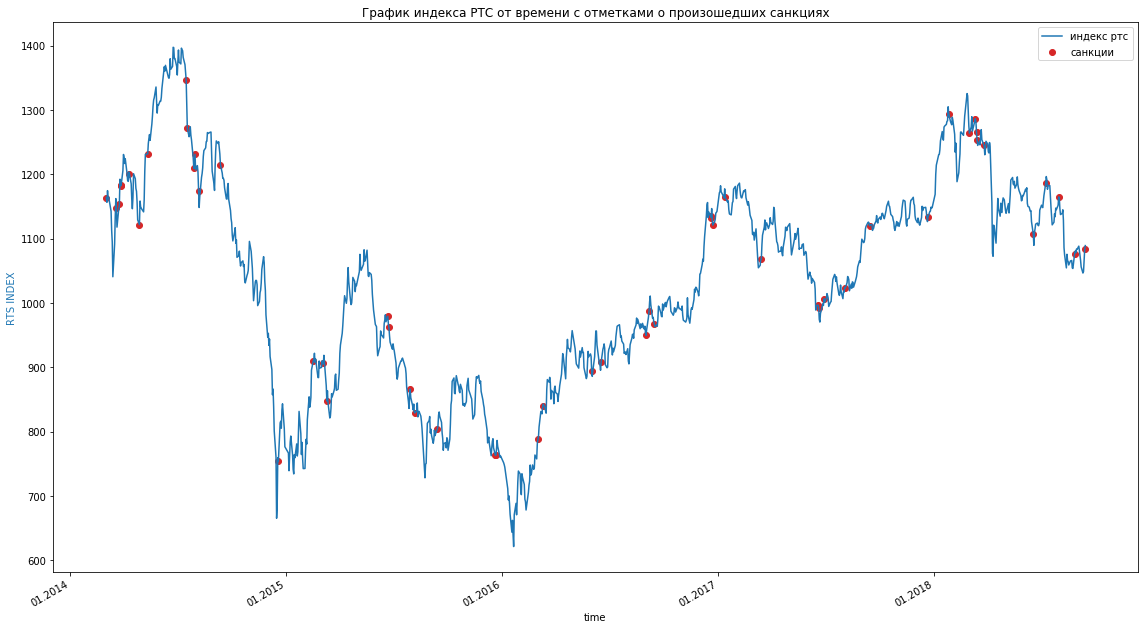

In [121]:
fmt = dates.DateFormatter('%m.%Y')
fig = plt.figure(figsize=(16, 10))
plt.title('График индекса РТС от времени с отметками о произошедших санкциях')


ax1 = plt.subplot()
color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('RTS INDEX', color=color)
ax1.plot(np.array(list(rts_index.keys())), np.array(list(rts_index.values())), color=color, label='индекс ртс')
ax1.xaxis.set_major_formatter(fmt)
ax1.legend()

ax2 = plt.subplot()

color = 'tab:red'
ax2.scatter(np.array(list(sanctions_indicator.keys())), np.array([rts_index[i] for i in sanctions_indicator.keys()]), color=color, label='санкции')
ax2.xaxis.set_major_formatter(fmt)
ax2.legend()

fig.tight_layout() 
fig.autofmt_xdate()
plt.show()

In [122]:
changes_in_rts_index = dict()
prev_value = None
for date, value in rts_index.items():
    if prev_value is None:
        prev_value = value
        continue
    else:
        changes_in_rts_index[date] = value - prev_value

Теперь посчитаем корреляцию между изменением индекса и вектором санкций

In [123]:
from scipy.stats import pearsonr

In [124]:
pearsonr(list(reversed(list(changes_in_rts_index.values()))), sanctions_vector)

(0.05470655822472861, 0.06447286512868944)

Теперь добавим информацию о датах твитов

In [125]:
tweet_dates = dict((v, 1) for v in sorted(list(trump_twits.values())))

In [126]:
tweet_dates

{datetime.date(2016, 12, 19): 1,
 datetime.date(2016, 12, 20): 1,
 datetime.date(2016, 12, 23): 1,
 datetime.date(2017, 1, 13): 1,
 datetime.date(2017, 6, 20): 1,
 datetime.date(2018, 3, 15): 1,
 datetime.date(2018, 3, 26): 1,
 datetime.date(2018, 7, 9): 1,
 datetime.date(2018, 8, 27): 1}

/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curr

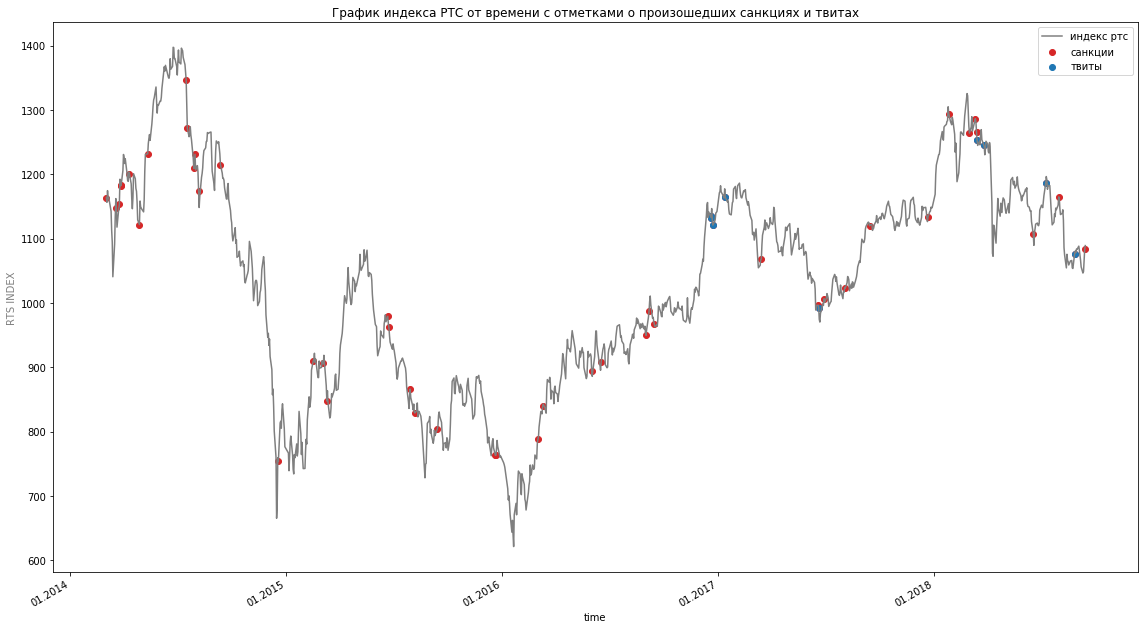

In [127]:
fmt = dates.DateFormatter('%m.%Y')
fig = plt.figure(figsize=(16, 10))
plt.title('График индекса РТС от времени с отметками о произошедших санкциях и твитах')


ax1 = plt.subplot()
color = 'tab:grey'
ax1.set_xlabel('time')
ax1.set_ylabel('RTS INDEX', color=color)
ax1.plot(np.array(list(rts_index.keys())), np.array(list(rts_index.values())), color=color, label='индекс ртс')
ax1.xaxis.set_major_formatter(fmt)
ax1.legend()

ax2 = plt.subplot()

color = 'tab:red'
ax2.scatter(np.array(list(sanctions_indicator.keys())), np.array([rts_index[i] for i in sanctions_indicator.keys()]), color=color, label='санкции')
ax2.xaxis.set_major_formatter(fmt)
ax2.legend()

ax3 = plt.subplot()

color = 'tab:blue'
ax3.scatter(np.array(list(tweet_dates.keys())), np.array([rts_index[i] for i in tweet_dates.keys()]), color=color, label='твиты')
ax3.xaxis.set_major_formatter(fmt)
ax3.legend()

fig.tight_layout() 
fig.autofmt_xdate()
plt.show()

In [128]:
start_date = datetime.strptime('01.10.2016', '%d.%m.%Y').date()
end_date = datetime.strptime('01.09.2018', '%d.%m.%Y').date()
changes_in_rts_index_slice = dict((k, v) for k, v in changes_in_rts_index.items() if k >= start_date and k <= end_date)
tweet_vector = []
last_twit = inf
last_sanction = inf
sanctions_vector = []
for single_date in daterange(start_date, end_date):
    if single_date in tweet_dates:
        last_twit = 0
    else:
        last_twit += 1
    if single_date in sanctions:
        last_sanction = 0
    else:
        last_sanction += 1
        
    if single_date not in changes_in_rts_index_slice:
        continue
        
    if last_twit < 4:
        tweet_vector.append(1)
    else:
        tweet_vector.append(0)
        
    if last_sanction < 4:
        sanctions_vector.append(1)
    else:
        sanctions_vector.append(0)

In [129]:
r, p = pearsonr(list(reversed(list(changes_in_rts_index_slice.values()))), tweet_vector)

In [130]:
r

0.047010418630939084

In [131]:
tweets_and_sanctions_vector = np.add(sanctions_vector, tweet_vector)

In [132]:
r, p = pearsonr(list(reversed(list(changes_in_rts_index_slice.values()))), tweets_and_sanctions_vector)

In [133]:
r

0.0718150616574035

## Повторим эксперимент для курса рубля

In [134]:
page_cbr = 'https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=28.02.2014&UniDbQuery.To=20.09.2018'

In [135]:
html_page_cbr = get_html_page(page_cbr)
soup_cbr = BeautifulSoup(html_page_cbr, 'html.parser')

In [136]:
def find_rubles_data(bf_soup):
    rubles_data = dict()
    table = bf_soup.find('table', class_='data')
    for tr in table.find_all('tr')[2:]:
        td = tr.find_all('td')
        date_obj = datetime.strptime(td[0].get_text(), '%d.%m.%Y').date()
        rubles_data[date_obj] = float(td[-1].get_text().replace(',', '.'))
    return dict((k, rubles_data[k]) for k in sorted(list(rubles_data.keys())))

In [137]:
rubles_data = find_rubles_data(soup_cbr)

In [138]:
rubles_data

{datetime.date(2014, 2, 28): 36.0501,
 datetime.date(2014, 3, 1): 36.1847,
 datetime.date(2014, 3, 4): 36.3784,
 datetime.date(2014, 3, 5): 36.3208,
 datetime.date(2014, 3, 6): 36.0849,
 datetime.date(2014, 3, 7): 36.1251,
 datetime.date(2014, 3, 8): 36.2618,
 datetime.date(2014, 3, 12): 36.4015,
 datetime.date(2014, 3, 13): 36.4865,
 datetime.date(2014, 3, 14): 36.4566,
 datetime.date(2014, 3, 15): 36.6391,
 datetime.date(2014, 3, 18): 36.6505,
 datetime.date(2014, 3, 19): 36.4487,
 datetime.date(2014, 3, 20): 36.207,
 datetime.date(2014, 3, 21): 36.1081,
 datetime.date(2014, 3, 22): 36.4022,
 datetime.date(2014, 3, 25): 36.1663,
 datetime.date(2014, 3, 26): 35.9316,
 datetime.date(2014, 3, 27): 35.4494,
 datetime.date(2014, 3, 28): 35.581,
 datetime.date(2014, 3, 29): 35.6871,
 datetime.date(2014, 4, 1): 35.6053,
 datetime.date(2014, 4, 2): 35.024,
 datetime.date(2014, 4, 3): 35.2517,
 datetime.date(2014, 4, 4): 35.5154,
 datetime.date(2014, 4, 5): 35.501,
 datetime.date(2014, 4, 8):

In [139]:
start_date = datetime.strptime('28.02.2014', '%d.%m.%Y').date()
end_date = datetime.strptime('21.09.2018', '%d.%m.%Y').date()

In [140]:
for single_date in daterange(start_date, end_date):
    if single_date not in rubles_data and (single_date in sanctions_indicator or single_date in tweet_dates):
        date_before = single_date - timedelta(1)
        while date_before not in rubles_data:
            date_before = date_before - timedelta(1)
        date_after = single_date + timedelta(1)
        while date_after not in rubles_data:
            date_after = date_after + timedelta(1)
        rubles_data[single_date] = (rubles_data[date_before] + rubles_data[date_after]) / 2
rubles_data = dict((k, rubles_data[k]) for k in sorted(list(rubles_data.keys())))

/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curr

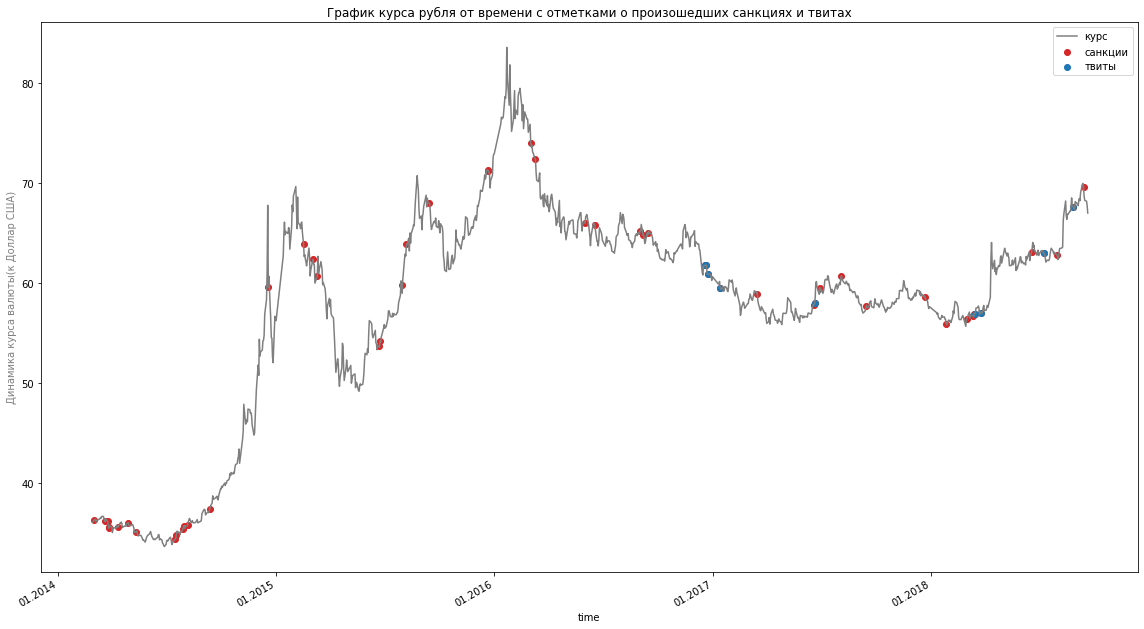

In [141]:
fmt = dates.DateFormatter('%m.%Y')
fig = plt.figure(figsize=(16, 10))
plt.title('График курса рубля от времени с отметками о произошедших санкциях и твитах')


ax1 = plt.subplot()
color = 'tab:grey'
ax1.set_xlabel('time')
ax1.set_ylabel('Динамика курса валюты(к Доллар США)', color=color)
ax1.plot(np.array(list(rubles_data.keys())), np.array(list(rubles_data.values())), color=color, label='курс')
ax1.xaxis.set_major_formatter(fmt)
ax1.legend()

ax2 = plt.subplot()

color = 'tab:red'
ax2.scatter(np.array(list(sanctions_indicator.keys())), np.array([rubles_data[i] for i in sanctions_indicator.keys()]), color=color, label='санкции')
ax2.xaxis.set_major_formatter(fmt)
ax2.legend()

ax3 = plt.subplot()

color = 'tab:blue'
ax3.scatter(np.array(list(tweet_dates.keys())), np.array([rubles_data[i] for i in tweet_dates.keys()]), color=color, label='твиты')
ax3.xaxis.set_major_formatter(fmt)
ax3.legend()

fig.tight_layout() 
fig.autofmt_xdate()
plt.show()

In [330]:
def changes(data):
    changes_in_data = dict()
    prev_value = None
    for date, value in data.items():
        if prev_value is None:
            prev_value = value
            continue
        else:
            changes_in_data[date] = prev_value - value
    return changes_in_data

In [331]:
changes_in_rubles_data = changes(rubles_data)

In [332]:
tweet_vector = []
last_twit = inf
last_sanction = inf
sanctions_vector = []
for single_date in daterange(start_date, end_date):
    if single_date in tweet_dates:
        last_twit = 0
    else:
        last_twit += 1
        
    if single_date in sanctions:
        last_sanction = 0
    else:
        last_sanction += 1
        
    if single_date not in changes_in_rubles_data:
        continue
        
    if last_twit < 4:
        tweet_vector.append(1)
    else:
        tweet_vector.append(0)
        
    if last_sanction < 4:
        sanctions_vector.append(1)
    else:
        sanctions_vector.append(0)

In [333]:
r, p = pearsonr(list(changes_in_rubles_data.values()), sanctions_vector)

In [334]:
r

0.06917778667958589

In [335]:
r, p = pearsonr(list(changes_in_rubles_data.values()), tweet_vector)

In [336]:
r

-0.046305216447333424

In [337]:
r, p = pearsonr(list(changes_in_rubles_data.values()), np.add(sanctions_vector, tweet_vector))

In [338]:
r

0.03929792855134327

## Повторим эксперимент для цен на нефть

In [339]:
page_neft_wti = 'https://www.finanz.ru/birzhevyye-tovary/arhiv-torgov/neft-cena/usd/28.2.2014_21.9.2018?type=wti'

In [340]:
def find_petroleum_data(page_url):
    driver = webdriver.Firefox()
    driver.get(page_url)
    time.sleep(15)
    petroleum = dict()
    table = driver.find_element_by_xpath('//*[@id="historic-price-list"]/div/div[2]/table')
    for tr in table.find_elements_by_tag_name('tr')[1:]:
        td = tr.find_elements_by_tag_name('td')
        date_obj = datetime.strptime(td[0].text, '%d.%m.%Y').date()
        petroleum[date_obj] = float(td[1].text.replace(',', '.'))
    driver.close()
    return dict((k, petroleum[k]) for k in sorted(list(petroleum.keys())))

In [341]:
petroleum_data_wti = find_petroleum_data(page_neft_wti)

In [342]:
petroleum_data_wti

{datetime.date(2014, 2, 28): 102.42,
 datetime.date(2014, 3, 3): 104.65,
 datetime.date(2014, 3, 4): 103.21,
 datetime.date(2014, 3, 5): 101.2,
 datetime.date(2014, 3, 6): 101.34,
 datetime.date(2014, 3, 7): 101.96,
 datetime.date(2014, 3, 10): 100.46,
 datetime.date(2014, 3, 11): 99.16,
 datetime.date(2014, 3, 12): 97.83,
 datetime.date(2014, 3, 13): 97.95,
 datetime.date(2014, 3, 14): 98.59,
 datetime.date(2014, 3, 17): 97.41,
 datetime.date(2014, 3, 18): 98.61,
 datetime.date(2014, 3, 19): 99.07,
 datetime.date(2014, 3, 20): 98.59,
 datetime.date(2014, 3, 21): 99.6,
 datetime.date(2014, 3, 24): 99.37,
 datetime.date(2014, 3, 25): 99.16,
 datetime.date(2014, 3, 26): 100.26,
 datetime.date(2014, 3, 27): 101.38,
 datetime.date(2014, 3, 28): 101.52,
 datetime.date(2014, 3, 31): 101.52,
 datetime.date(2014, 4, 1): 99.49,
 datetime.date(2014, 4, 2): 99.44,
 datetime.date(2014, 4, 3): 100.42,
 datetime.date(2014, 4, 4): 101.17,
 datetime.date(2014, 4, 7): 99.92,
 datetime.date(2014, 4, 8):

In [343]:
start_date = datetime.strptime('28.02.2014', '%d.%m.%Y').date()
end_date = datetime.strptime('21.09.2018', '%d.%m.%Y').date()

/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curr

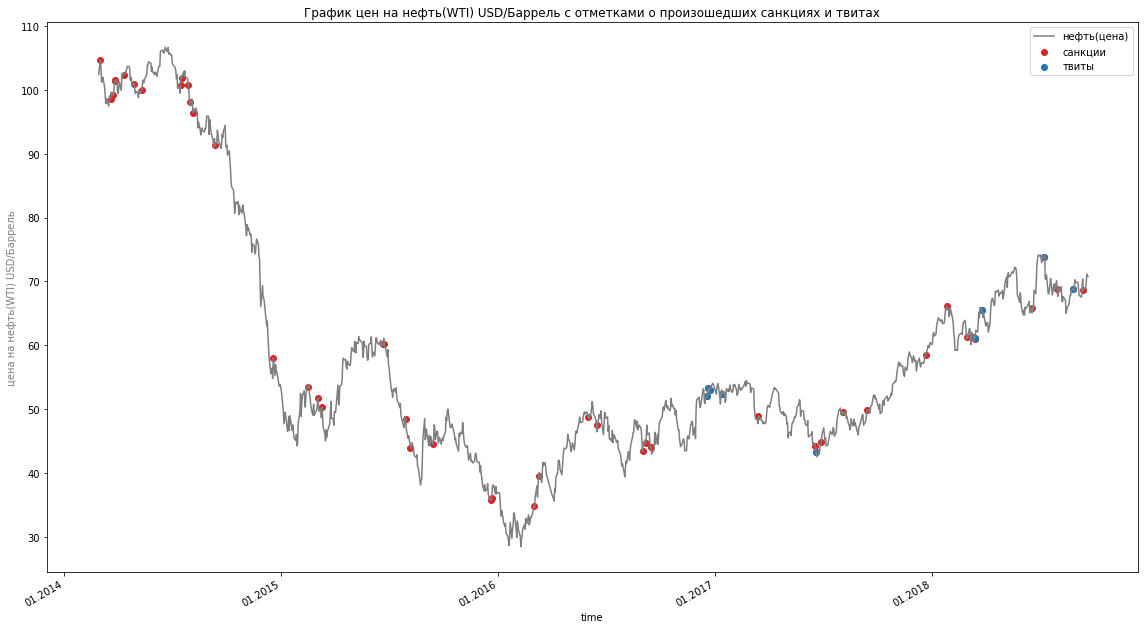

In [344]:
fmt = dates.DateFormatter('%m.%Y')
fig = plt.figure(figsize=(16, 10))
plt.title('График цен на нефть(WTI) USD/Баррель с отметками о произошедших санкциях и твитах')


ax1 = plt.subplot()
color = 'tab:grey'
ax1.set_xlabel('time')
ax1.set_ylabel('цена на нефть(WTI) USD/Баррель', color=color)
ax1.plot(np.array(list(petroleum_data_wti.keys())), np.array(list(petroleum_data_wti.values())), color=color, label='нефть(цена)')
ax1.xaxis.set_major_formatter(fmt)
ax1.legend()

ax2 = plt.subplot()

color = 'tab:red'
ax2.scatter(np.array(list(sanctions_indicator.keys())), np.array([petroleum_data_wti[i] for i in sanctions_indicator.keys()]), color=color, label='санкции')
ax2.xaxis.set_major_formatter(fmt)
ax2.legend()

ax3 = plt.subplot()

color = 'tab:blue'
ax3.scatter(np.array(list(tweet_dates.keys())), np.array([petroleum_data_wti[i] for i in tweet_dates.keys()]), color=color, label='твиты')
ax3.xaxis.set_major_formatter(fmt)
ax3.legend()

fig.tight_layout() 
fig.autofmt_xdate()
plt.show()

In [345]:
def find_vectors(data):
    changes_in_data = dict()
    prev_value = None
    for date, value in data.items():
        if prev_value is None:
            prev_value = value
        elif date >= start_date and date < end_date:
            changes_in_data[date] = value - prev_value
            
    tweet_vector = []
    last_twit = inf
    last_sanction = inf
    sanctions_vector = []
    for single_date in daterange(start_date, end_date):
        if single_date in tweet_dates:
            last_twit = 0
        else:
            last_twit += 1

        if single_date in sanctions:
            last_sanction = 0
        else:
            last_sanction += 1

        if single_date not in changes_in_data:
            continue

        if last_twit < 4:
            tweet_vector.append(1)
        else:
            tweet_vector.append(0)
        if last_sanction < 4:
            sanctions_vector.append(1)
        else:
            sanctions_vector.append(0)
    return changes_in_data, tweet_vector, sanctions_vector

In [346]:
changes_in_petroleum_data_wti, tweet_vector, sanctions_vector = find_vectors(petroleum_data_wti)

In [347]:
pearsonr(list(changes_in_petroleum_data_wti.values()), sanctions_vector)

(0.11900219912169625, 4.805307977296084e-05)

In [348]:
pearsonr(list(changes_in_petroleum_data_wti.values()), tweet_vector)

(0.004316438200596571, 0.8831965887147182)

In [349]:
pearsonr(list(changes_in_petroleum_data_wti.values()), np.add(sanctions_vector, tweet_vector))

(0.09683469596266557, 0.0009541634449164082)

### Для brent

In [350]:
page_brent = 'https://www.finanz.ru/birzhevyye-tovary/arhiv-torgov/neft-cena/usd/28.2.2014_21.9.2018?type=brent'

In [351]:
petroleum_data_brent = find_petroleum_data(page_brent)

In [352]:
petroleum_data_brent

{datetime.date(2014, 2, 28): 108.91,
 datetime.date(2014, 3, 3): 110.8,
 datetime.date(2014, 3, 4): 109.11,
 datetime.date(2014, 3, 5): 107.8,
 datetime.date(2014, 3, 6): 108.51,
 datetime.date(2014, 3, 7): 108.81,
 datetime.date(2014, 3, 10): 107.91,
 datetime.date(2014, 3, 11): 108.3,
 datetime.date(2014, 3, 12): 108.2,
 datetime.date(2014, 3, 13): 106.8,
 datetime.date(2014, 3, 14): 108.21,
 datetime.date(2014, 3, 17): 106.2,
 datetime.date(2014, 3, 18): 106.51,
 datetime.date(2014, 3, 19): 105.91,
 datetime.date(2014, 3, 20): 106.11,
 datetime.date(2014, 3, 21): 107.01,
 datetime.date(2014, 3, 24): 106.61,
 datetime.date(2014, 3, 25): 106.9,
 datetime.date(2014, 3, 26): 106.91,
 datetime.date(2014, 3, 27): 107.7,
 datetime.date(2014, 3, 28): 108.01,
 datetime.date(2014, 3, 31): 107.8,
 datetime.date(2014, 4, 1): 105.51,
 datetime.date(2014, 4, 2): 104.71,
 datetime.date(2014, 4, 3): 106.3,
 datetime.date(2014, 4, 4): 106.7,
 datetime.date(2014, 4, 7): 105.91,
 datetime.date(2014, 4

/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/alaska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curr

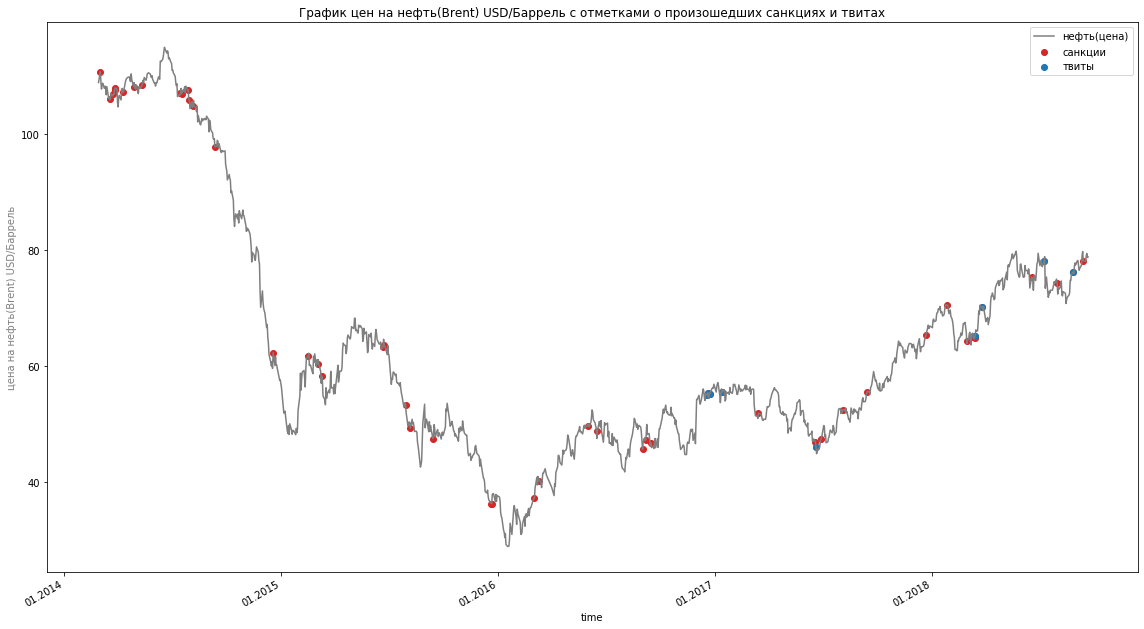

In [353]:
fmt = dates.DateFormatter('%m.%Y')
fig = plt.figure(figsize=(16, 10))
plt.title('График цен на нефть(Brent) USD/Баррель с отметками о произошедших санкциях и твитах')


ax1 = plt.subplot()
color = 'tab:grey'
ax1.set_xlabel('time')
ax1.set_ylabel('цена на нефть(Brent) USD/Баррель', color=color)
ax1.plot(np.array(list(petroleum_data_brent.keys())), np.array(list(petroleum_data_brent.values())), color=color, label='нефть(цена)')
ax1.xaxis.set_major_formatter(fmt)
ax1.legend()

ax2 = plt.subplot()

color = 'tab:red'
ax2.scatter(np.array(list(sanctions_indicator.keys())), np.array([petroleum_data_brent[i] for i in sanctions_indicator.keys()]), color=color, label='санкции')
ax2.xaxis.set_major_formatter(fmt)
ax2.legend()

ax3 = plt.subplot()

color = 'tab:blue'
ax3.scatter(np.array(list(tweet_dates.keys())), np.array([petroleum_data_brent[i] for i in tweet_dates.keys()]), color=color, label='твиты')
ax3.xaxis.set_major_formatter(fmt)
ax3.legend()

fig.tight_layout() 
fig.autofmt_xdate()
plt.show()

In [354]:
changes_in_petroleum_data_brent, tweet_vector, sanctions_vector = find_vectors(petroleum_data)

In [355]:
pearsonr(list(changes_in_petroleum_data_brent.values()), sanctions_vector)

(0.11900219912169625, 4.805307977296084e-05)

In [356]:
pearsonr(list(changes_in_petroleum_data_brent.values()), tweet_vector)

(0.004316438200596571, 0.8831965887147182)

In [357]:
pearsonr(list(changes_in_petroleum_data_brent.values()), np.add(sanctions_vector, tweet_vector))

(0.09683469596266557, 0.0009541634449164082)

# Далее, попробуем выяснить, влияли ли цены на нефть на курс рубля и индекс rts

In [435]:
from sklearn.linear_model import LinearRegression

In [436]:
def clear_data(data1, data2):
    dates = sorted(list(set(data1.keys()).intersection(data2.keys())))
    x = np.array([data1[d] for d in dates])
    y = np.array([data2[d] for d in dates])
    print('before pearsonr', pearsonr(x, y))
    model = LinearRegression().fit(x.reshape((-1, 1)), -y)
    print('coefficient of determination:', model.score(x.reshape((-1, 1)), -y))
    y_cleared = np.abs(-y - model.intercept_ - model.coef_ * x)
    print('after pearsonr', pearsonr(x, y_cleared))
    return {d:i for d, i in zip(dates, y_cleared)}

In [437]:
rts_index_cleared = clear_data(petroleum_data_wti, dict(sorted(rts_index.items())))

before pearsonr (0.7188867380307966, 3.810694225679096e-178)
coefficient of determination: 0.5167981421165588
after pearsonr (-0.12967472181646345, 1.3896202205388625e-05)


In [438]:
rubles_data_cleared = clear_data(petroleum_data_wti, rubles_data)

before pearsonr (-0.8881819908139594, 3.358076076584558e-306)
coefficient of determination: 0.7888672488062485
after pearsonr (0.03690529651121574, 0.2681951093917768)


# Попробуем вычислить зависимость между санкциями и новыми, очищенными данными по курсу рубля и ртс

In [439]:
changes_in_rts_index_cleared, tweet_vector, sanctions_vector = find_vectors(rts_index_cleared)

In [440]:
rts_index_cleared = {k:v for k,v in rts_index_cleared.items() if k in changes_in_rts_index_cleared}

In [441]:
pearsonr(list(rts_index_cleared.values()), sanctions_vector)

(0.018128189266446496, 0.545378183287315)

In [442]:
pearsonr(list(rts_index_cleared.values()), tweet_vector)

(0.027023186586411757, 0.36732233872197817)

In [443]:
pearsonr(list(rts_index_cleared.values()), np.add(sanctions_vector, tweet_vector))

(0.024206782465484793, 0.41936968415102016)

In [444]:
changes_in_rubles_data_cleared, tweet_vector, sanctions_vector = find_vectors(rubles_data_cleared)

In [445]:
rubles_data_cleared = {k:v for k,v in rubles_data_cleared.items() if k in changes_in_rubles_data_cleared}

In [446]:
pearsonr(list(rubles_data_cleared.values()), sanctions_vector)

(0.012194106804457904, 0.7147144416997984)

In [447]:
pearsonr(list(rubles_data_cleared.values()), tweet_vector)

(0.12609815841119634, 0.0001476738827363903)

In [448]:
pearsonr(list(rubles_data_cleared.values()), np.add(sanctions_vector, tweet_vector))

(0.05598422629339319, 0.0930655443397274)